# Function Testing Notebook - Matrix Difference Plot

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster

In [2]:
# packageroot = Path('../../').resolve()
packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/home/dongjp/source-code/PyEEG


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [3]:
core.set_temp_directory('/scr1/users/dongjp')

## Test WAR

In [9]:
# wars = []
# animal_ids = ['A10', 'F22']
# for animal_id in animal_ids:
#     # REVIEW consider making this process a single one-line function
#     war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
#     war = war.filter_all()
#     wars.append(war)

#     sars = []
#     for path in Path('./test-sars/').glob(f'*{animal_id}*'):
#         sars.append(visualization.SpikeAnalysisResult.load_fif_and_json(path))
#     war.read_sars_spikes(sars, read_mode='mne')

# ep = visualization.ExperimentPlotter(wars)


In [ ]:
wars = []
animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
for animal_id in animal_ids:
    # REVIEW consider making this process a single one-line function
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())
    war = war.filter_all()
    wars.append(war)

    # sars = []
    # for path in Path('./test-sars/').glob(f'*{animal_id}*'):
    #     sars.append(visualization.SpikeAnalysisResult.load_fif_and_json(path))
    # war.read_sars_spikes(sars, read_mode='mne')

ep = visualization.ExperimentPlotter(wars)


In [5]:
for feat in constants.LINEAR_FEATURE:
    logging.info(f'pulling {feat}')
    ep.pull_timeseries_dataframe(feat, ['genotype','animalday'])

df2 = ep.pull_timeseries_dataframe('rms', ['genotype','animal'], collapse_channels=True)

/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:141: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)
/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/experiment.py:141: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


In [6]:
# g = ep.plot_catplot('psdband', ['animal'], 
#                     collapse_channels=False, hue='channel', col='band',
#                     # stat_pairs='x',
#                     # stat_pairs=[[('A10 KO Dec-13-2023', 'theta'), ('F22 KO Dec-12-2023', 'delta')]],
#                     # stat_pairs=[[('F22', 'delta'), ('F22', 'theta')], [('F22', 'theta'), ('A10', 'theta')]], 
#                     # stat_pairs=[[('F22', 'delta'), ('F22', 'theta')], [('F22', 'theta'), ('A10', 'theta')]], 
#                     # stat_pairs=perms,
#                     # stat_test='Brunner-Munzel',
#                     # norm_test='log-D-Agostino',
#                     )

In [7]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()

2025-04-09 00:11:53,763 - DEBUG - groups: ['KO']
2025-04-09 00:11:53,766 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-04-09 00:11:53,766 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-04-09 00:11:53,774 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-04-09 00:11:53,778 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-04-09 00:11:53,801 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-09 00:11:53,804 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-09 00:11:53,813 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-04-09 00:11:53,816 - DEBUG - findfont: score(FontEntry(fname='/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-09 00:11:53,816 - DEBUG - findfont: score(F

ValueError: No rows found for ['genotype'] != ('KO',)

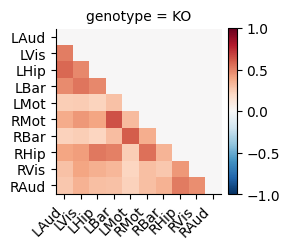

In [8]:
ep.plot_heatmap('cohere', 'genotype')
ep.plot_diffheatmap('cohere', 'genotype', baseline_key='KO')
# df = ep.plot_diffheatmap('cohere', ['animalday', 'genotype'], baseline_key=('A10 KO Dec-13-2023', 'KO'))
